In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from glob import glob
import os
import TOC_functions
%matplotlib widget

In [2]:
root_folder = os.path.expanduser('C:/Users/ica/OneDrive - Plymouth Marine Laboratory/vscode/TOC_analysis/data/2025/02')  # yourpath
picarro_df = TOC_functions.merge_picarro_files(root_folder)
picarro_df = TOC_functions.qc(picarro_df)
picarro_df.set_index('datetime', inplace=True)



In [36]:
# filter by time

start_time = datetime.datetime(2025, 2, 3  , 18, 0, 0)
end_time = datetime.datetime(2025, 2, 4, 16, 59, 0)

In [37]:

df = picarro_df.loc[start_time:end_time]

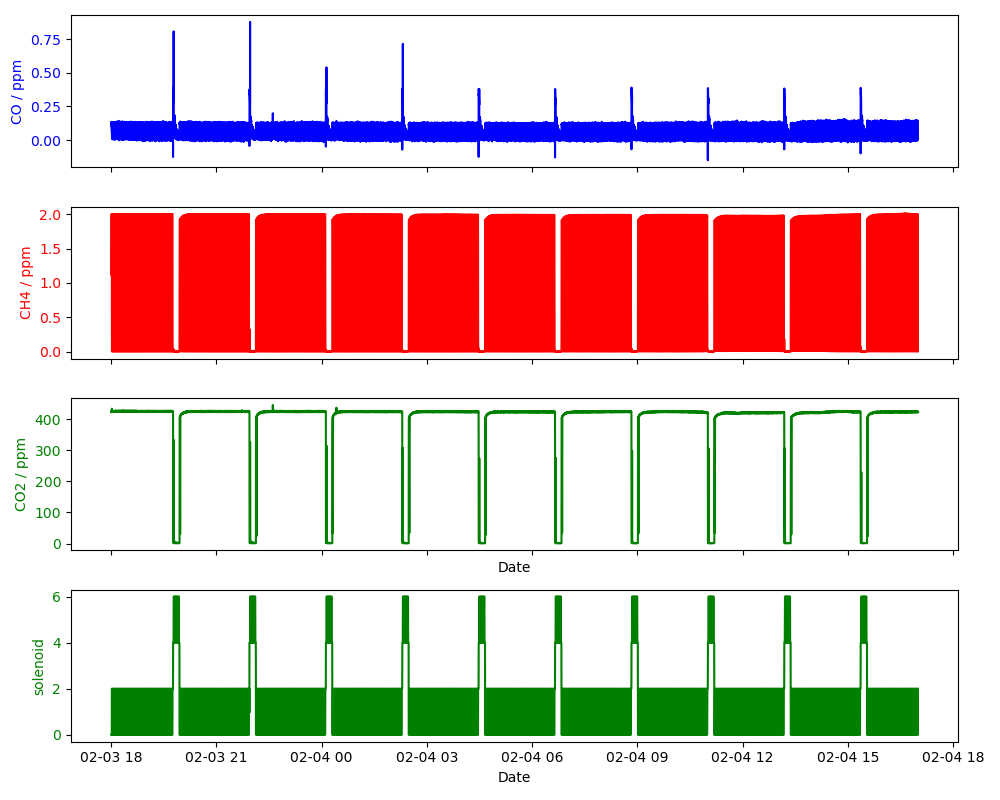

In [6]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, sharex=True, figsize=(10, 8))
#fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(10, 8))

# Plot for CO
ax1.plot(df.index, df.CO, label='CO / ppm', color='blue')
ax1.set_ylabel('CO / ppm', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Plot for CH4
ax2.plot(df.index, df.CH4, label='CH4 / ppm', color='red')
ax2.set_ylabel('CH4 / ppm', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Plot for CO2
ax3.plot(df.index, df.CO2, label='CO2 / ppm', color='green')
ax3.set_xlabel('Date')
ax3.set_ylabel('CO2 / ppm', color='green')
ax3.tick_params(axis='y', labelcolor='green')

ax4.plot(df.index, df.solenoid_valves, label='', color='green')
ax4.set_xlabel('Date')
ax4.set_ylabel('solenoid', color='green')
ax4.tick_params(axis='y', labelcolor='green')


# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

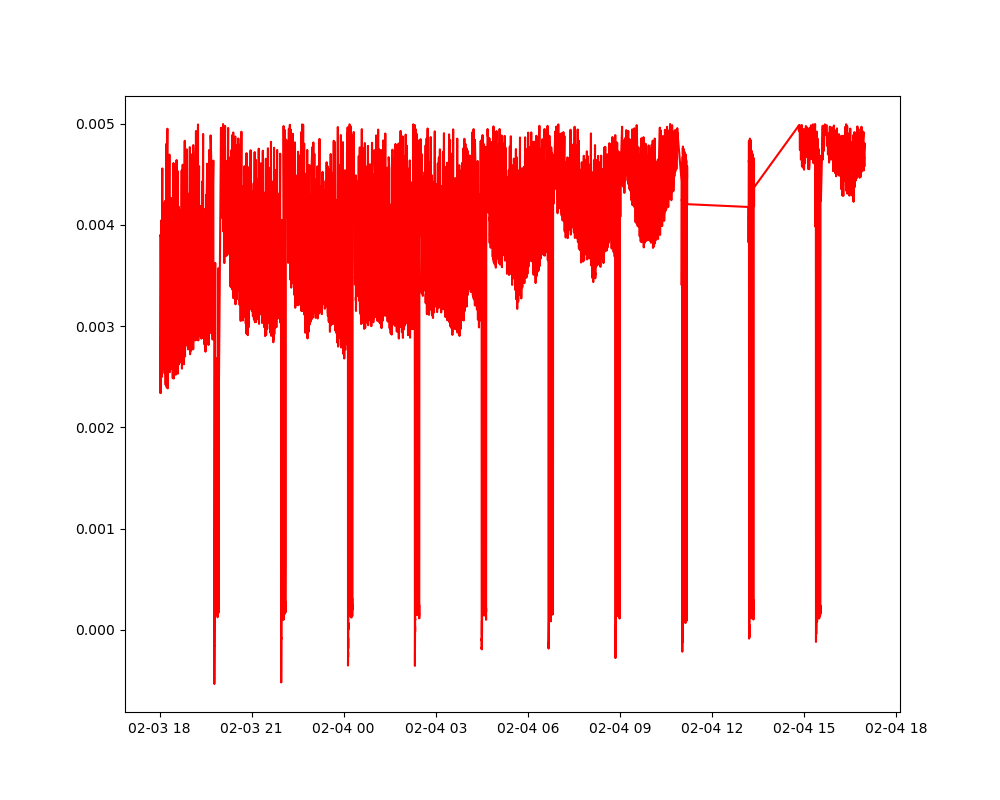

In [7]:
df_methane = df[df['CH4'] <0.005]
plt.figure(figsize=(10, 8))
plt.plot(df_methane.index, df_methane['CH4'], label='CH4 / ppm', color='red')
plt.show()

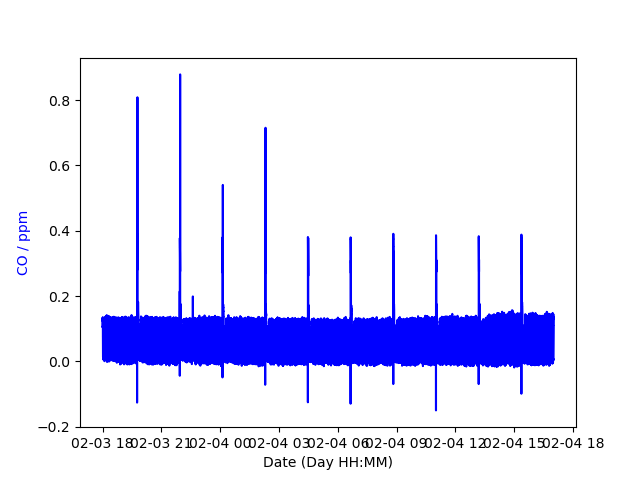

In [8]:
plt.figure()
plt.plot(df.index, df.CO, label='CO / ppm', color='blue')  
plt.xlabel('Date (Day HH:MM)')
plt.ylabel('CO / ppm', color='blue') 
plt.show()

In [29]:

df_blanks = df[df['solenoid_valves'] >= 3.9]


In [30]:
# TOC averages
TOC_df_blank =TOC_functions.TOC_df_blank(df_blanks)



In [31]:
toc = TOC_functions.calculate_toc(TOC_df_blank)
#toc = toc[toc['TOC'] <= 0.25]


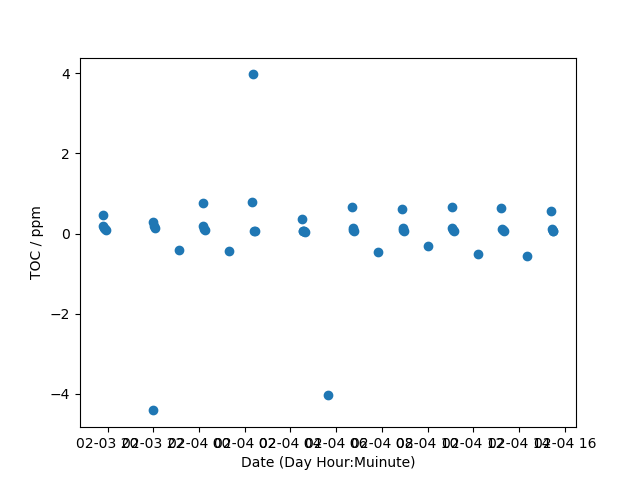

In [32]:
plt.figure()
plt.scatter(toc.index, toc['TOC'])
plt.ylabel('TOC / ppm')
plt.xlabel('Date (Day Hour:Muinute)')
plt.show()

In [27]:
toc.mean()

TOC    0.031773
dtype: float64

In [38]:
df = df[df['solenoid_valves'] <= 3]

In [ ]:
avg_times = []
avg_co2_ambient = []
avg_co2_catalyst = []
avg_ch4_ambient = []
avg_ch4_catalyst = []
avg_co_ambient = []
avg_co_catalyst = []

# detect for valve changes
valve_change = df[(df['solenoid_valves'] != 2.0) & (df['solenoid_valves'] != 0.0)]  # valve =2 is catalyst
                                                                                    # valve = 0 is ambient

# averages before valve changes
for i in valve_change.index:
    #  time window (25s before valve change, ending 2s before)
    end_time = i - pd.Timedelta(seconds=2)
    start_time = end_time - pd.Timedelta(seconds=42)
    
    # get data in the main df within time window
    window_df = df[(df.index > start_time) & (df.index < end_time)]
    
    # averages
    avg_co2 = window_df['CO2_corrected'].mean()
    avg_ch4 = window_df['CH4_corrected'].mean()
    avg_co = window_df['CO'].mean()
    avg_valve = window_df['solenoid_valves'].mean()
    avg_time_val = window_df.index.mean()
    avg_times.append(avg_time_val)

    # sort appropriate lists based on valve state
    if avg_valve == 2.0:  # catalyst
        avg_co2_catalyst.append(avg_co2)
        avg_ch4_catalyst.append(avg_ch4)
        avg_co_catalyst.append(avg_co)
        avg_co2_ambient.append(np.nan)
        avg_ch4_ambient.append(np.nan)
        avg_co_ambient.append(np.nan)
    elif avg_valve == 0.0:  # ambient
        avg_co2_ambient.append(avg_co2)
        avg_ch4_ambient.append(avg_ch4)
        avg_co_ambient.append(avg_co)
        avg_co2_catalyst.append(np.nan)
        avg_ch4_catalyst.append(np.nan)
        avg_co_catalyst.append(np.nan)

# create results df
TOC_df = pd.DataFrame({
    'datetime': avg_times[:-7],
    'avg_co2_ambient': avg_co2_ambient,
    'avg_ch4_ambient': avg_ch4_ambient,
    'avg_co_ambient': avg_co_ambient,
    'avg_co2_catalyst': avg_co2_catalyst,
    'avg_ch4_catalyst': avg_ch4_catalyst,
    'avg_co_catalyst': avg_co_catalyst

})




In [51]:
TOC_df =TOC_df.set_index('datetime')

toc_results = []

for i in range(0, len(TOC_df) - 1, 2):
    pair = TOC_df.iloc[i:i+2]

    # Sum catalyst and ambient values
    sum_catalyst = pair[['avg_co2_catalyst', 'avg_ch4_catalyst', 'avg_co_catalyst']].sum().sum()
    sum_ambient = pair[['avg_co2_ambient', 'avg_ch4_ambient', 'avg_co_ambient']].sum().sum()
    
    # Calculate TOC
    toc = sum_catalyst - sum_ambient
    
    # Store result with mean timestamp
    mean_time = pair.index.mean()  # Mean timestamp
    toc_results.append({'datetime': mean_time, 'TOC': toc})  

# Create and return DataFrame
toc_results_df= pd.DataFrame(toc_results).set_index('datetime')  


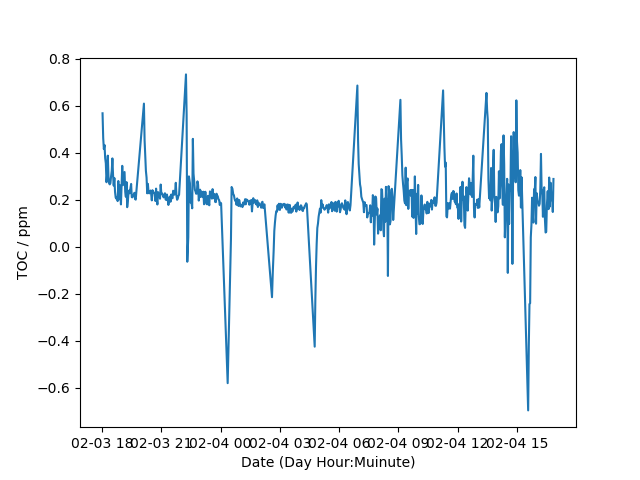

In [59]:
toc_results_df = toc_results_df[toc_results_df['TOC'] <=0.75]
toc_results_df = toc_results_df[toc_results_df['TOC'] >=-0.75]

plt.figure()
plt.plot(toc_results_df.index, toc_results_df['TOC'])
plt.ylabel('TOC / ppm')
plt.xlabel('Date (Day Hour:Muinute)')
plt.show()